<a href="https://colab.research.google.com/github/towardsai/ai-tutor-rag-system/blob/main/notebooks/04-RAG_with_VectorStore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Packages and Setup Variables


In [1]:
# !pip install -q openai==1.107.0 chromadb==1.0.21 google-genai==1.36.0 llama-index==0.14.0 llama-index-llms-google-genai==0.3.0 langchain==0.3.27 \
#                 llama-index-vector-stores-chroma==0.5.2 langchain-chroma==0.2.5 langchain-openai==0.3.32 langchain-google-genai==2.0.10 \
#                 jedi==0.19.2

In [2]:
import os
# Set the following API Keys in the Python environment. Will be used later.
# os.environ["OPENAI_API_KEY"] = "<YOUR_API_KEY>"
# os.environ["GOOGLE_API_KEY"] = "<YOUR_API_KEY>"

# from google.colab import userdata
# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
# os.environ["GOOGLE_API_KEY"] = userdata.get('Google_api_key')
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env

True

# Load the Dataset (CSV)


## Download


The dataset includes several articles from the TowardsAI blog, which provide an in-depth explanation of the LLaMA2 model. Read the dataset as a long string.


In [3]:
# !curl -o ./mini-dataset.csv https://raw.githubusercontent.com/AlaFalaki/tutorial_notebooks/main/data/mini-llama-articles.csv

## Read File


In [4]:
import csv

text = ""

# Load the file as a JSON
with open("./mini-llama-articles.csv", mode="r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)

    for idx, row in enumerate(csv_reader):
        if idx == 0:
            continue
        text += row[1]

# The number of characters in the dataset.
print(len(text))

171044


# Chunking


In [5]:
chunk_size = 512
chunks = []

# Split the long text into smaller manageable chunks of 512 characters.
for i in range(0, len(text), chunk_size):
    chunks.append(text[i : i + chunk_size])

print(len(chunks))

335


#Interface of Chroma with LlamaIndex


In [6]:
from llama_index.core import Document

# Convert the chunks to Document objects so the LlamaIndex framework can process them.
doc_chunks = [Document(text=chunk) for chunk in chunks]

c:\DROPBOX\Документы\Карзановы\Андрей\__CHALLENGES\AI_Full_Stack_Developer\.venv\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


In [7]:
len(doc_chunks)

335

## Save on Chroma -> changed to Qdrant


In [8]:
# import chromadb

# # create client and a new collection
# # chromadb.EphemeralClient saves data in-memory.
# chroma_client = chromadb.PersistentClient(path="./mini-chunked-dataset")
# chroma_collection = chroma_client.create_collection("mini-chunked-dataset")

from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

In [9]:

# create client with persistent storage
# qdrant_client = QdrantClient(path="./mini-chunked-dataset")

server_id = "192.168.162.240"
# If you are running Qdrant in a Docker container on your local machine, use the

qdrant_client = QdrantClient(url=f"http://{server_id}:6333")

In [10]:
qdrant_client.get_collections().collections

[CollectionDescription(name='Part3_DDofDS'),
 CollectionDescription(name='Part3_DDofDS_1_10'),
 CollectionDescription(name='scifact'),
 CollectionDescription(name='document_chat'),
 CollectionDescription(name='mini-chunked-dataset'),
 CollectionDescription(name='Part6-linkedin-posts'),
 CollectionDescription(name='Part3_DDofDS_SQuAD'),
 CollectionDescription(name='graphRAGstoreds'),
 CollectionDescription(name='Part4_Attention'),
 CollectionDescription(name='chat_with_docs'),
 CollectionDescription(name='graphRAG_FIXED_test'),
 CollectionDescription(name='Part3_DDofDS_SQuAD_qb')]

In [11]:

collection_name = "mini-chunked-dataset"

if not qdrant_client.collection_exists(collection_name):

    print(f"Creating collection '{collection_name}'...")
    # create a new collection
    # You must specify vector size and distance metric
    qdrant_client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(
            # size=384,  # dimension of your embeddings (e.g., 384 for all-MiniLM-L6-v2)
            size=1536,  # dimension of your embeddings (e.g., 1536 for text-embedding-3-small)
            distance=Distance.COSINE,  # or Distance.EUCLID, Distance.DOT
        ),
    )
else:
    # qdrant_client.delete_collection(collection_name=collection_name)
    print(f"Collection '{collection_name}' already exists.")

Collection 'mini-chunked-dataset' already exists.


In [12]:
# !llama-index-vector-stores-qdrant

In [13]:
# from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
from llama_index.vector_stores.qdrant import QdrantVectorStore

# Define a storage context object using the created vector database.
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
vector_store = QdrantVectorStore(client=qdrant_client, collection_name="mini-chunked-dataset")
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [14]:
from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.openai import OpenAIEmbedding

# Build index / generate embeddings using OpenAI embedding model
index = VectorStoreIndex.from_documents(
    doc_chunks,
    embed_model=OpenAIEmbedding(model="text-embedding-3-small"),
    storage_context=storage_context,
    show_progress=True,
)

Parsing nodes:   0%|          | 0/335 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/335 [00:00<?, ?it/s]

## Query Dataset


In [15]:
# !pip install llama-index-llms-openrouter

In [ ]:
# Define a query engine that is responsible for retrieving related pieces of text,
# and using a LLM to formulate the final answer.

# from llama_index.llms.google_genai import GoogleGenAI

# llm = GoogleGenAI(model="gemini-2.5-flash",max_tokens=512, temperature=1)

from llama_index.llms.openai import OpenAI

llm_openai = OpenAI(model="gpt-4.1-mini", max_tokens=512, temperature=1)
query_engine_openai = index.as_query_engine(llm=llm_openai, similarity_top_k=5)

In [18]:
response = query_engine_openai.query("How many parameters LLaMA2 model has?")
print(response)

LLaMA 2 models are available in four different sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters.


In [19]:
from llama_index.llms.openrouter import OpenRouter

# !pip install llama-index-llms-openrouter
llm_openrouter = OpenRouter(
    model="google/gemini-2.5-flash",
    max_tokens=512,
    temperature=1,
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

query_engine_openrouter = index.as_query_engine(llm=llm_openrouter, similarity_top_k=5)


In [20]:
response = query_engine_openrouter.query("How many parameters LLaMA2 model has?")
print(response)

The Llama 2 model comes in four different sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters.


# Interface of Chroma (Qdrant) with LangChain


In [6]:
# from llama_index.core import Document

# # Convert the chunks to Document objects so the LlamaIndex framework can process them.
# doc_chunks = [Document(text=chunk) for chunk in chunks]


from langchain.schema.document import Document

# Convert the chunks to Document objects so the LangChain framework can process them.
# documents = [Document(page_content=t) for t in chunks]
doc_chunks = [Document(page_content=chunk) for chunk in chunks]

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [7]:
len(doc_chunks)

335

## Save on Chroma


In [9]:
# from langchain_chroma import Chroma
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient

from langchain_openai import OpenAIEmbeddings


load_dotenv(override=True)

# Create Qdrant client with persistent storage
# qdrant_client = QdrantClient(path="./mini-chunked-dataset")
server_id = os.getenv("server_id")
# If you are running Qdrant in a Docker container on your local machine, use the
qdrant_client = QdrantClient(url=f"http://{server_id}:6333")


# Add the documents to chroma DB and create Index / embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# chroma_db = Chroma.from_documents(
#     documents=doc_chunks,
#     embedding=embeddings,
#     persist_directory="./mini-chunked-dataset",
#     collection_name="mini-chunked-dataset",
# )

# Add documents to Qdrant and create index/embeddings
qdrant_db = QdrantVectorStore.from_documents(
    documents=doc_chunks,
    embedding=embeddings,
    collection_name="mini-chunked-dataset_langchain",
    # client=qdrant_client, # Original Qdrant client, SHOULD NOT BE USED WITHIN LangChain (it creates its own client inside)
	url=f"http://{server_id}:6333"
)

## Query Dataset


In [29]:
load_dotenv(override=True)


True

In [30]:
# from langchain_google_genai import ChatGoogleGenerativeAI

# # Initializing the LLM model
# #llm = ChatOpenAI(temperature=0, model="gpt-4o-mini", max_tokens=512)

# llm = ChatGoogleGenerativeAI(
#     model="gemini-2.5-flash",
#     temperature=0,
#     max_tokens=512,
# )

# from langchain_openai import ChatOpenAI
from langchain_openai import ChatOpenAI
# from langchain_openrouter import ChatOpenRouter

# Initialize LLM via OpenRouter
# llm_langchain = ChatOpenRouter(
llm_langchain = ChatOpenAI(
    model="google/gemini-2.5-flash",
    temperature=0,
    max_tokens=512,
    openai_api_key=os.getenv("OPENROUTER_API_KEY"),
    openai_api_base="https://openrouter.ai/api/v1"
)

In [31]:
llm_langchain.invoke(input ="Explain the theory of relativity in simple terms.")

AIMessage(content='Imagine you\'re on a train, and someone walks past you. To you, they\'re walking at a certain speed. But to someone standing on the ground watching the train go by, that person is moving much faster because you have to add the speed of the train to their walking speed. This simple idea is a good starting point for understanding **relativity**.\n\nAt its core, the theory of relativity, developed by Albert Einstein, is about how **space and time are not absolute and fixed, but are relative to the observer\'s motion.**\n\nLet\'s break it down into two main parts:\n\n---\n\n### 1. Special Relativity (1905)\n\nThis part deals with how space and time are relative when things are moving at a **constant speed** (not accelerating). It\'s built on two revolutionary ideas:\n\n*   **The laws of physics are the same for everyone, no matter how fast they\'re moving (as long as it\'s a constant speed).**\n    *   Think of it like this: If you\'re on a train moving at a constant spe

In [33]:
from langchain.chains import RetrievalQA

query = "How many parameters LLaMA 2 model has?"

# retriever = chroma_db.as_retriever(search_kwargs={"k": 4})
retriever = qdrant_db.as_retriever(search_kwargs={"k": 4})


# Define a RetrievalQA chain that is responsible for retrieving related pieces of text,
# and using a LLM to formulate the final answer.
chain = RetrievalQA.from_chain_type(llm=llm_langchain, chain_type="stuff", retriever=retriever)

response = chain.invoke(query)
print(response["result"])

The LLaMA 2 model is available in four different sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters.


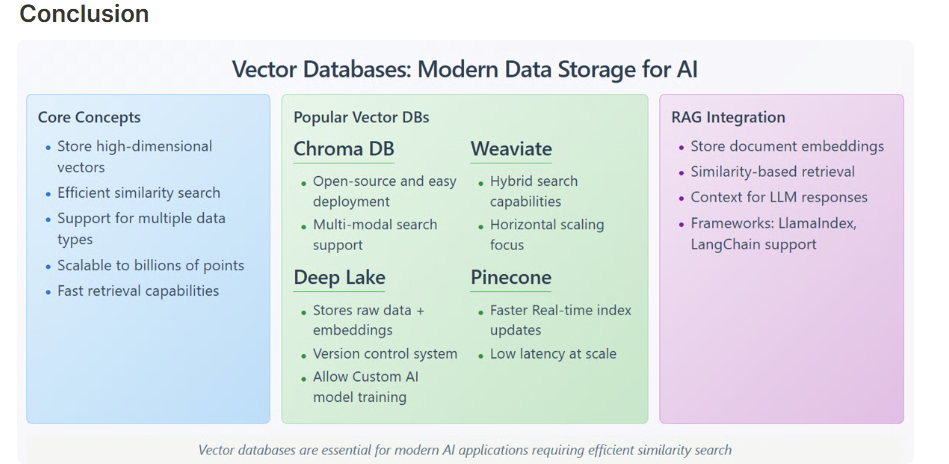